# This is a document that tries keras on jupyter notebook

## Several notes for 11.17
1. Normalizing input data is essential
2. for categorical result, even though there are only two categories, use multi output and softmax. This is necessary as for calculating output in real cases, there are more variables to compare to, thus higher security of a good result.
3. it is high time to redo the training with __class reweighting__.!!!!

In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
import re
from gensim.models.wrappers.fasttext import FastText as FT_wrapper
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential, Model, load_model
from keras.layers import Bidirectional
from keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout, AlphaDropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add, subtract
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.initializers import VarianceScaling, RandomUniform
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
import time
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# visualization tool
class RealTimeVisualizer(Callback):
    def on_train_begin(self, logs={}):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2,1, sharex=True)
        self.fig.suptitle(self.title, fontsize=24)
        self.fig.set_size_inches(20, 8)
        self.index_graph = []
        self.loss_graph = []
        self.val_loss_graph = []
        self.acc_graph = []
        self.val_acc_graph = []
 
    def on_epoch_end(self, epoch, logs={}):
        interval = self.interval
        loss = logs['loss']
        val_loss = logs['val_loss']
        try:
            val_acc = logs['val_acc']
        except:
            val_acc = logs['val_mean_squared_error']    
        try:
            acc = logs['acc']
        except:
            acc = logs['mean_squared_error']
        if epoch%interval == 0:
            self.loss_graph.append(loss)
            self.val_loss_graph.append(val_loss)
            self.val_acc_graph.append(val_acc)
            self.acc_graph.append(acc)
            self.index_graph.append(epoch)
            if interval == 1:
                self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
                self.ax1.plot(self.index_graph, self.loss_graph, '-r')
                self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
                self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
                self.ax2.plot(self.index_graph, self.acc_graph, '-r')
                self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
                self.ax2.plot(self.index_graph, [self.acc_graph[0]]*len(self.index_graph), '-p')
                self.fig.canvas.draw()
                time.sleep(0.05)
        elif epoch%interval == interval-1:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc
            self.loss_graph[int(epoch/interval)] /= interval
            self.val_loss_graph[int(epoch/interval)] /= interval
            self.val_acc_graph[int(epoch/interval)] /= interval
            self.acc_graph[int(epoch/interval)] /= interval
            self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
            self.ax1.plot(self.index_graph, self.loss_graph, '-r')
            self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
            self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
            self.ax2.plot(self.index_graph, self.acc_graph, '-r')
            self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
            self.ax2.plot(self.index_graph, [self.acc_graph[0]]*len(self.index_graph), '-p')
            self.fig.canvas.draw()
            time.sleep(0.05)
        else:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc

VisualizeCallback = RealTimeVisualizer()
VisualizeCallback.interval = 2
VisualizeCallback.title = "plot"

In [ ]:
# load w2v vector model
word_vector_len = 300
wv_model = KeyedVectors.load_word2vec_format("word2vec/w2v_data/wiki-news-300d-1M.vec")
# load my word vector 
# wv_model = KeyedVectors.load("word2vec/w2v_data/fasttext_wv_64")

In [4]:
def pad_vector_sequence(sequences, max_len): # pad before and truncate after
    global word_vector_len
    padded_sequences = []
    for seq in sequences:
        seq_len = seq.shape[0]
        vec_len = seq.shape[1]
        if max_len > seq_len:
            zeros = np.zeros((max_len - seq_len, word_vector_len))
            new_seq = np.vstack([zeros, seq])
        else:
            new_seq = seq[:max_len]
        padded_sequences.append(new_seq)
    return np.array(padded_sequences)

In [40]:
def is_desired_letter(char):
    return ord(char) >= 97 and ord(char) < 123 or ord(char) >= 48 and ord(char) < 58 or ord(char) == ord(" ")


# return even number of 0 and 1 if is_even_result is True
def get_train_data(train_portion, wv_model, is_even_test_data=True, is_neg_1_as_0=False, is_second_round_data=False, normalize_portion=0.45):
    np.random.seed(7)
    # load the dataset but only keep the top n words, zero the rest
    train_data = pd.read_csv("../input/kickstarter_train.csv")
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    # do preliminary preprocessing:remove all symbols and split to words lists
    train_data["desc"] = [[char for char in str(text).lower() if is_desired_letter(char)] for
                          text in train_data["desc"]]
    train_data["desc"] = [''.join(text).split() for text in train_data["desc"]]
    # remove words that cannot be expressed
    train_data["desc"] = [[word for word in text if word in wv_model] for text in train_data["desc"]]
    # word 2 vector
    train_data["desc"] = [np.array(list(map(wv_model.word_vec, text))) for text in train_data["desc"]]
    # remove too short desc
    drop_index = []
    for i in range(len(train_data)):
        if train_data.iloc[i, 2].shape[0] <= 2:
            drop_index.append(i)
    train_data = train_data.drop(train_data.index[drop_index])
    
    # tokenize all countries
    # load dictionary or genrate one online
    try:
        country_dict = Dictionary.load("../num_model/num_data/country_dict.pkl")
        print("loading country dictionary successful from disk")
    except:
        print("No country dictionary available, generating from data")
        country_dict = Dictionary([train_data.iloc[:, 6]])
        country_dict.save("../num_model/num_data/country_dict.pkl")
        print("new dictionary saved to num_data")
    # start tokenization
    try:
        train_data.iloc[:, 6] = np.array(list(map(country_dict.token2id.get, train_data.iloc[:, 6]))) # map gives extra speed~
    except:
        print("Warning!!! A country does not exist in current dictionary!!!")
    
    # count zeros and ones and get weights for each sample
    counter = train_data.iloc[:, -1].value_counts().to_dict()
    zeros = float(counter[0])
    ones = float(counter[1])
    max_result = max(zeros, ones)
    weights = [ones / max_result, zeros / max_result]
    
    # get goal normalization para
    normalize_split_point = int(normalize_portion * len(train_data))
    temp_train_goals = np.array(train_data.iloc[:normalize_split_point, 3])
    goal_mean = temp_train_goals.mean()
    goal_std = temp_train_goals.std()
    
    # get backer normalization para
    temp_train_backers = np.array(train_data.iloc[:normalize_split_point, -2])
    backer_mean = temp_train_backers.mean()
    backer_std = temp_train_backers.std()
    
    # seperate train and test data
    if is_second_round_data == False:
        split_point = int(train_portion * len(train_data))
        test_data = train_data.iloc[split_point:, :]
        train_data = train_data.iloc[:split_point, :]
    else:
        split_point = int(train_portion * len(train_data))
        split_point_2 = int(train_portion * len(train_data) * 2)
        test_data = train_data.iloc[split_point_2:, :]
        train_data = train_data.iloc[split_point:split_point_2, :]
        
    # even test data
    # for test data count 0 and drop some until sample of 1 = sample of 0
    if is_even_test_data:
        print("even test data")
        status_count = test_data.iloc[:, -1].value_counts().to_dict()
        drop_zero_num = status_count[0] - status_count[1]
        drop_zero_p = drop_zero_num / float(status_count[0])
        drop_index = []
        for i in range(len(test_data)):
            if test_data.iloc[i, -1] == 0:
                if np.random.uniform(low=0, high=1) < drop_zero_p:
                    drop_index.append(i)
        test_data = test_data.drop(test_data.index[drop_index])
        status_count = test_data.iloc[:, -1].value_counts().to_dict()
        print(float(status_count[0]) / float(status_count[1]))
        # shuffle the whole data
        test_data = test_data.sample(frac=1).reset_index(drop=True)
    else:
        print("do not even test data")

    # get descriptions data
    train_texts = np.array(train_data.iloc[:, 2])
    test_texts = np.array(test_data.iloc[:, 2])
    # get goal data
    train_goals = (np.array(train_data.iloc[:, 3]) - goal_mean) / goal_std
    test_goals = (np.array(test_data.iloc[:, 3]) - goal_mean) / goal_std
    # get backer data
    # train_backers = (np.array(train_data.iloc[:, -2]) - backer_mean) / backer_std
    # test_backers = (np.array(test_data.iloc[:, -2]) - backer_mean) / backer_std
    train_backers = np.array(train_data.iloc[:, -2])
    test_backers = np.array(test_data.iloc[:, -2])
    # get country data
    train_countries = np.array(train_data.iloc[:, 6])
    test_countries = np.array(train_data.iloc[:, 6])
    # get result data
    train_results_double = np.array([[1, 0] if item == 1 else [0, 1] for item in train_data.iloc[:, -1]])
    train_results_single = np.array(train_data.iloc[:, -1])
    train_weights = np.array([weights[i] for i in train_data.iloc[:, -1]])
    test_results_double = np.array([[1, 0] if item == 1 else [0, 1] for item in test_data.iloc[:, -1]])
    test_results_single = np.array(test_data.iloc[:, -1])
    # test_weights = np.array([weights[i] for i in test_data.iloc[:, -1]])
    # convert 1, 0 results to 1, -1
    if is_neg_1_as_0:
        train_results_single = np.array([1 if item == 1 else -1 for item in train_results_single])
        test_results_single = np.array([1 if item == 1 else -1 for item in test_results_single])
        train_results_double = np.array([[1, -1] if item[0] == 1 else [-1, 1] for item in train_results_double])
        test_results_double = np.array([[1, -1] if item[0] == 1 else [-1, 1] for item in test_results_double])

    
    return {"texts": train_texts, "countries": train_countries, "goals": train_goals, "backers": train_backers,
            "results_double": train_results_double, "results_single": train_results_single, 
            "result_class_weight": train_weights}, \
           {"texts": test_texts, "countries": test_countries, "goals": test_goals, "backers": test_backers,
            "results_double": test_results_double, "results_single": test_results_single}, 

In [41]:
# get training testing data from disk
train_portion = 0.45
train_data, test_data = get_train_data(train_portion, wv_model=wv_model, is_even_test_data=False)
print("data grabbed")

loading country dictionary successful from disk
1.0001060670343658
data grabbed


In [42]:
# truncate and pad input sequences
max_desc_length = 35
train_data["texts"] = pad_vector_sequence(train_data["texts"], max_len=max_desc_length)
test_data["texts"] = pad_vector_sequence(test_data["texts"], max_len=max_desc_length)
print("padding finished")

padding finished


 # Let's try use Conv1D with resFork and sigmoid output
__It turns out that conv networks has the maximum accuracy of only 61 percent, compared to LSTM networks' 63 percent__
__It's even more fantastic that LSTM takes only 100 epoch to converge to its best__

In [70]:
def DenseNetCell(dense_in, dropout_level=0.25, res_num=1, activation_name="tanh", l2_para=0.001):
    this_input = dense_in
    for i in range(res_num):
        if activation_name != 'selu':
            x = Dense(int(fork_in.shape[1]), activity_regularizer=l2(l2_para))(this_input)
            x = BatchNormalization()(x)
            x = Activation(activation_name)(x) 
            x = Dropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = BatchNormalization()(res_out)
            this_input = Activation(activation_name)(x)
        else:
            x = Dense(int(fork_in.shape[1]), kernel_initializer=
                        VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
                        activity_regularizer=l2(l2_para))(this_input)
            x = Activation(activation_name)(x)
            x = AlphaDropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            this_input = Activation(activation_name)(x)
    dense_out = Dense(1)(this_input)
    return dense_out

desc_conv_input = Input(shape=(35, word_vector_len))
x = Conv1D(filters=16, kernel_size=5, activation='relu')(desc_conv_input)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=16, kernel_size=3, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=4)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
fork_in = Dropout(0.2)(x)
x = concatenate(inputs=[DenseNetCell(fork_in, dropout_level=0.25, res_num=1, activation_name="selu", l2_para=0.001), 
                               DenseNetCell(fork_in, dropout_level=0.25, res_num=1, activation_name="selu", l2_para=0.001)])
x = Activation("selu")(x)
x = Activation("softmax")(x)

desc_conv_model = Model(inputs=[desc_conv_input], outputs=[x])

desc_conv_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=["accuracy"])
print("model building finished\n", desc_conv_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 35, 64)       0                                            
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 31, 16)       5136        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 31, 16)       124         conv1d_29[0][0]                  
__________________________________________________________________________________________________
dropout_49 (Dropout)            (None, 31, 16)       0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
conv1d_30 

<IPython.core.display.Javascript object>


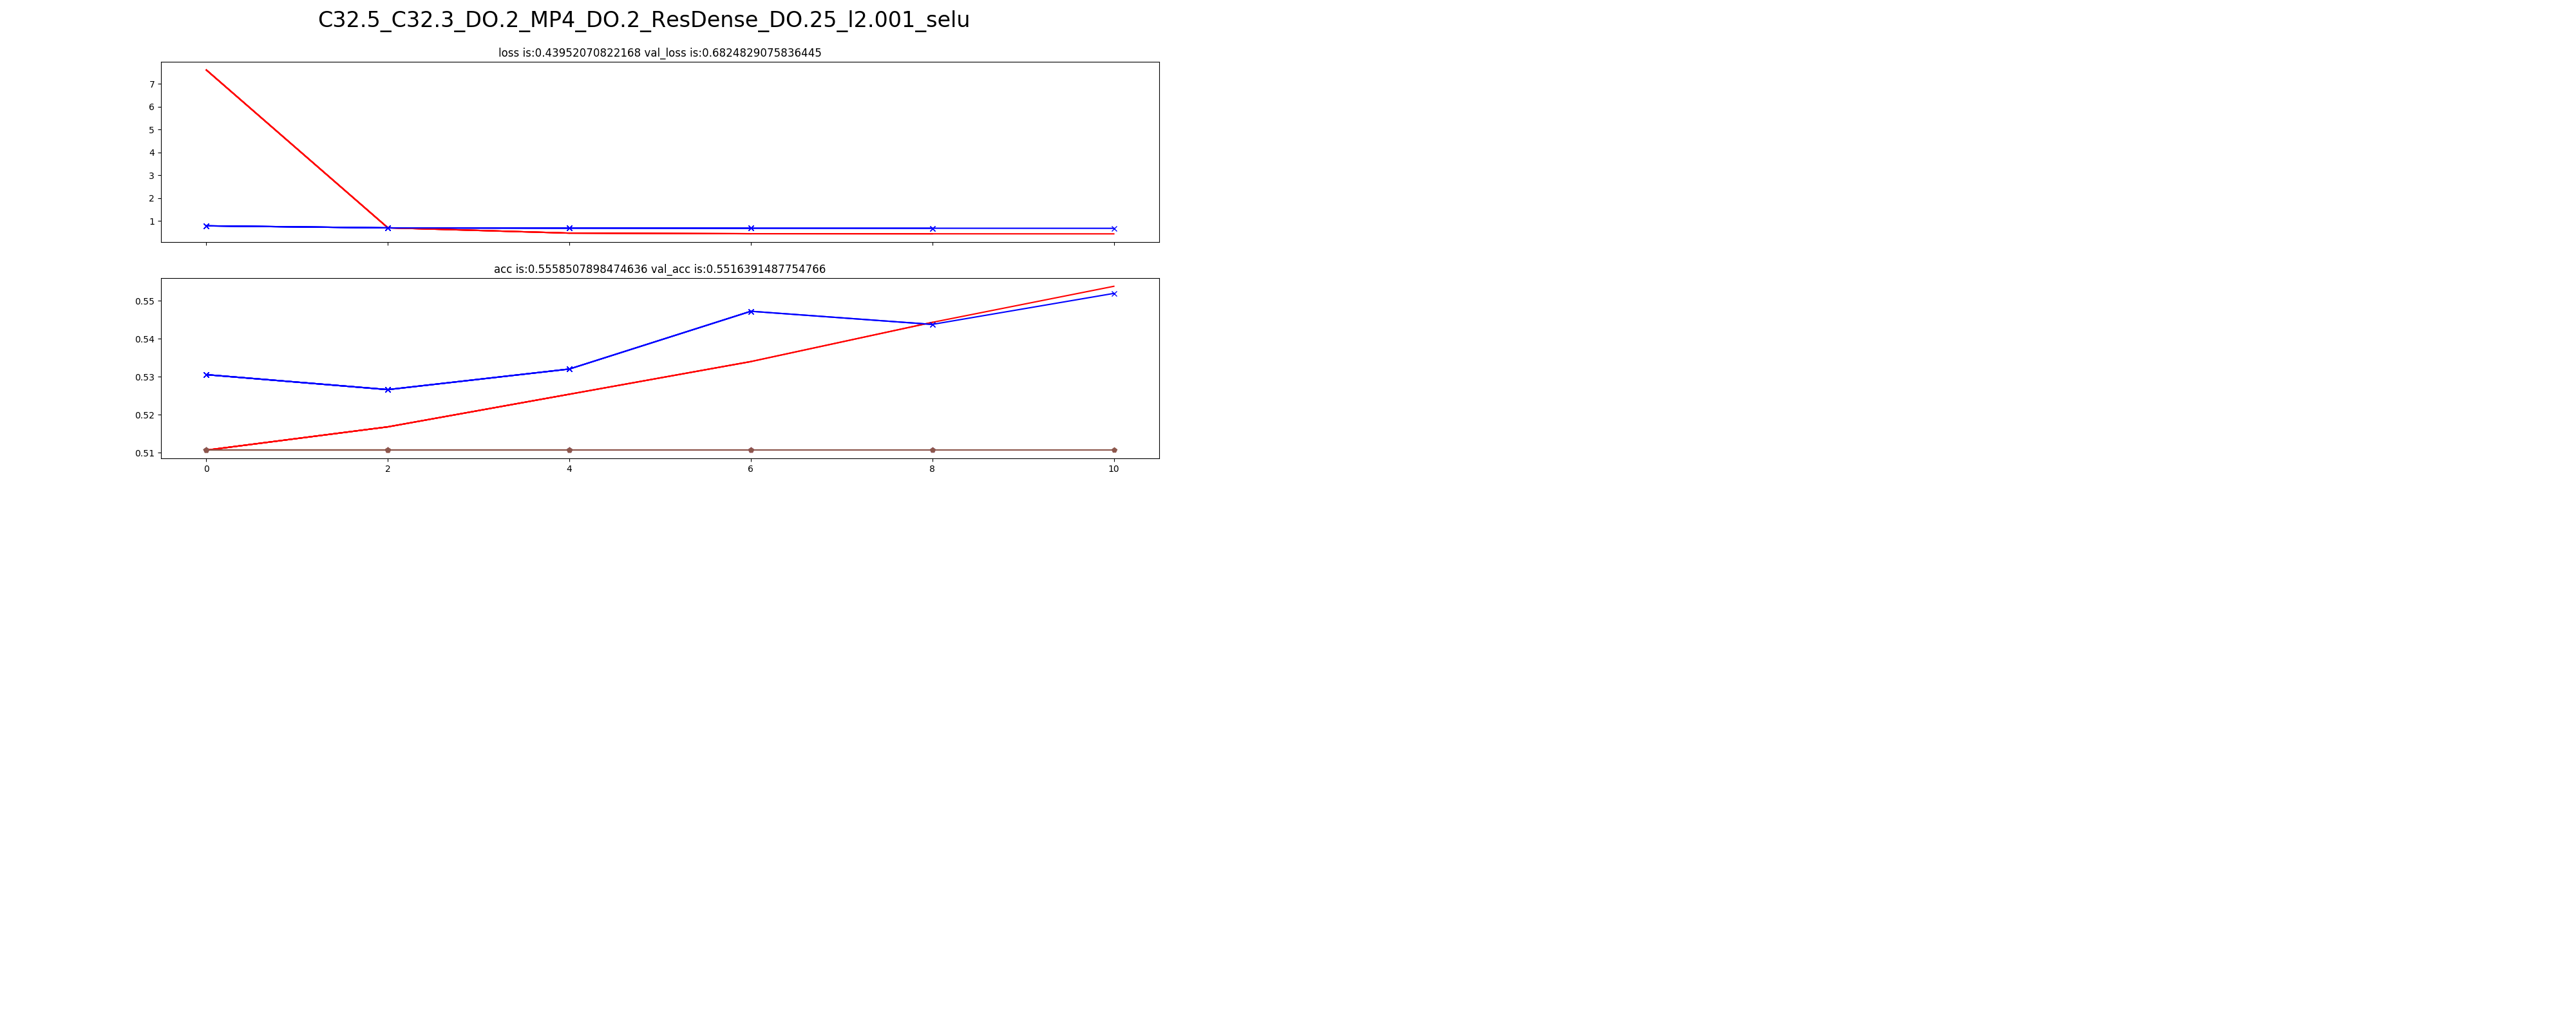

In [ ]:
# do training
VisualizeCallback.title = "C32.5_C32.3_DO.2_MP4_DO.2_ResDense_DO.25_l2.001_selu"
desc_conv_model.fit(train_data['texts'], train_data['results_double'], epochs=1000, batch_size=256, shuffle=True,
                  verbose=0, validation_data=[test_data["texts"], test_data['results_double']], 
                  callbacks=[ReduceLROnPlateau(patience=10, min_lr=0.00001, cooldown=30), VisualizeCallback],
                   sample_weight=train_data['result_class_weight'])

scores = desc_conv_model.evaluate(x=[test_data['texts']], y=[test_data['results_double']])
desc_conv_model.save("desc_data/desc_conv_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

In [61]:
scores = desc_conv_model.evaluate(x=[test_data['texts']], y=[test_data['results_double']])
print(scores)
desc_conv_model.save("desc_data/desc_conv_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

37733/37733 [==============================] - 3s 83us/step


# Now use LSTM with forking (and residue to lstm output)
__seemingly using forked_sigmoid classifier is easier to converge than forked_softmax classifier__

__using SVM leads to a faster convergence rate yet similar (~0.61) test accuracy__

__using selu (of course with alpha dropout and custom weight initialization) leads to a faster convergence rate of test accuracy, and after some fine-tuning (with batch size 256), the test accuracy has reached it's historical best:0.638__

In [19]:
def MultiLayerLSTMCell(sequence_input, dropout_level=0.2, layer_num=1, layer_width=32):
    this_input = sequence_input
    for i in range(layer_num):
        if i == layer_num - 1:
            is_return_sequence = False
        else:
            is_return_sequence = True
        x = LSTM(units=layer_width, dropout=dropout_level, name="Recurrent_" + str(i), 
                 return_sequences=is_return_sequence)(this_input)
        this_input = BatchNormalization()(x)
    return this_input

def DenseNetCell(dense_in, dropout_level=0.25, res_num=1, activation_name="tanh", l2_para=0.001):
    this_input = dense_in
    for i in range(res_num):
        if activation_name != 'selu':
            x = Dense(int(fork_in.shape[1]), activity_regularizer=l2(l2_para))(this_input)
            x = BatchNormalization()(x)
            x = Activation(activation_name)(x) 
            x = Dropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = BatchNormalization()(res_out)
            x = Dropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
        else:
            x = Dense(int(this_input.shape[1]), kernel_initializer=
                        VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
                        activity_regularizer=l2(l2_para))(this_input)
            x = Activation(activation_name)(x)
            x = AlphaDropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = AlphaDropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
    dense_out = Dense(1)(this_input)
    return dense_out


# generate model for descriptions + country
desc_rnn_input = Input(shape=(35, word_vector_len))
x = MultiLayerLSTMCell(desc_rnn_input, dropout_level=0.2, layer_num=1, layer_width=64)
x = BatchNormalization()(x)
fork_in = Dropout(0.2)(x)
# fork network for isolately decide is 1 or is 0
x = concatenate(inputs=[DenseNetCell(fork_in, dropout_level=0.2, res_num=2, activation_name="selu", l2_para=0.0001), 
                               DenseNetCell(fork_in, dropout_level=0.2, res_num=2, activation_name="selu", l2_para=0.0001)])
x = Activation("selu")(x)
x = Activation("softmax")(x)
desc_rnn_model = Model(inputs=[desc_rnn_input], outputs=[x])

print("model building finished\n", desc_rnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35, 300)      0                                            
__________________________________________________________________________________________________
Recurrent_0 (LSTM)              (None, 64)           93440       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64)           256         Recurrent_0[0][0]                
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 64)           256         batch_normalization_5[0][0]      
__________________________________________________________________________________________________
dropout_4 

<IPython.core.display.Javascript object>


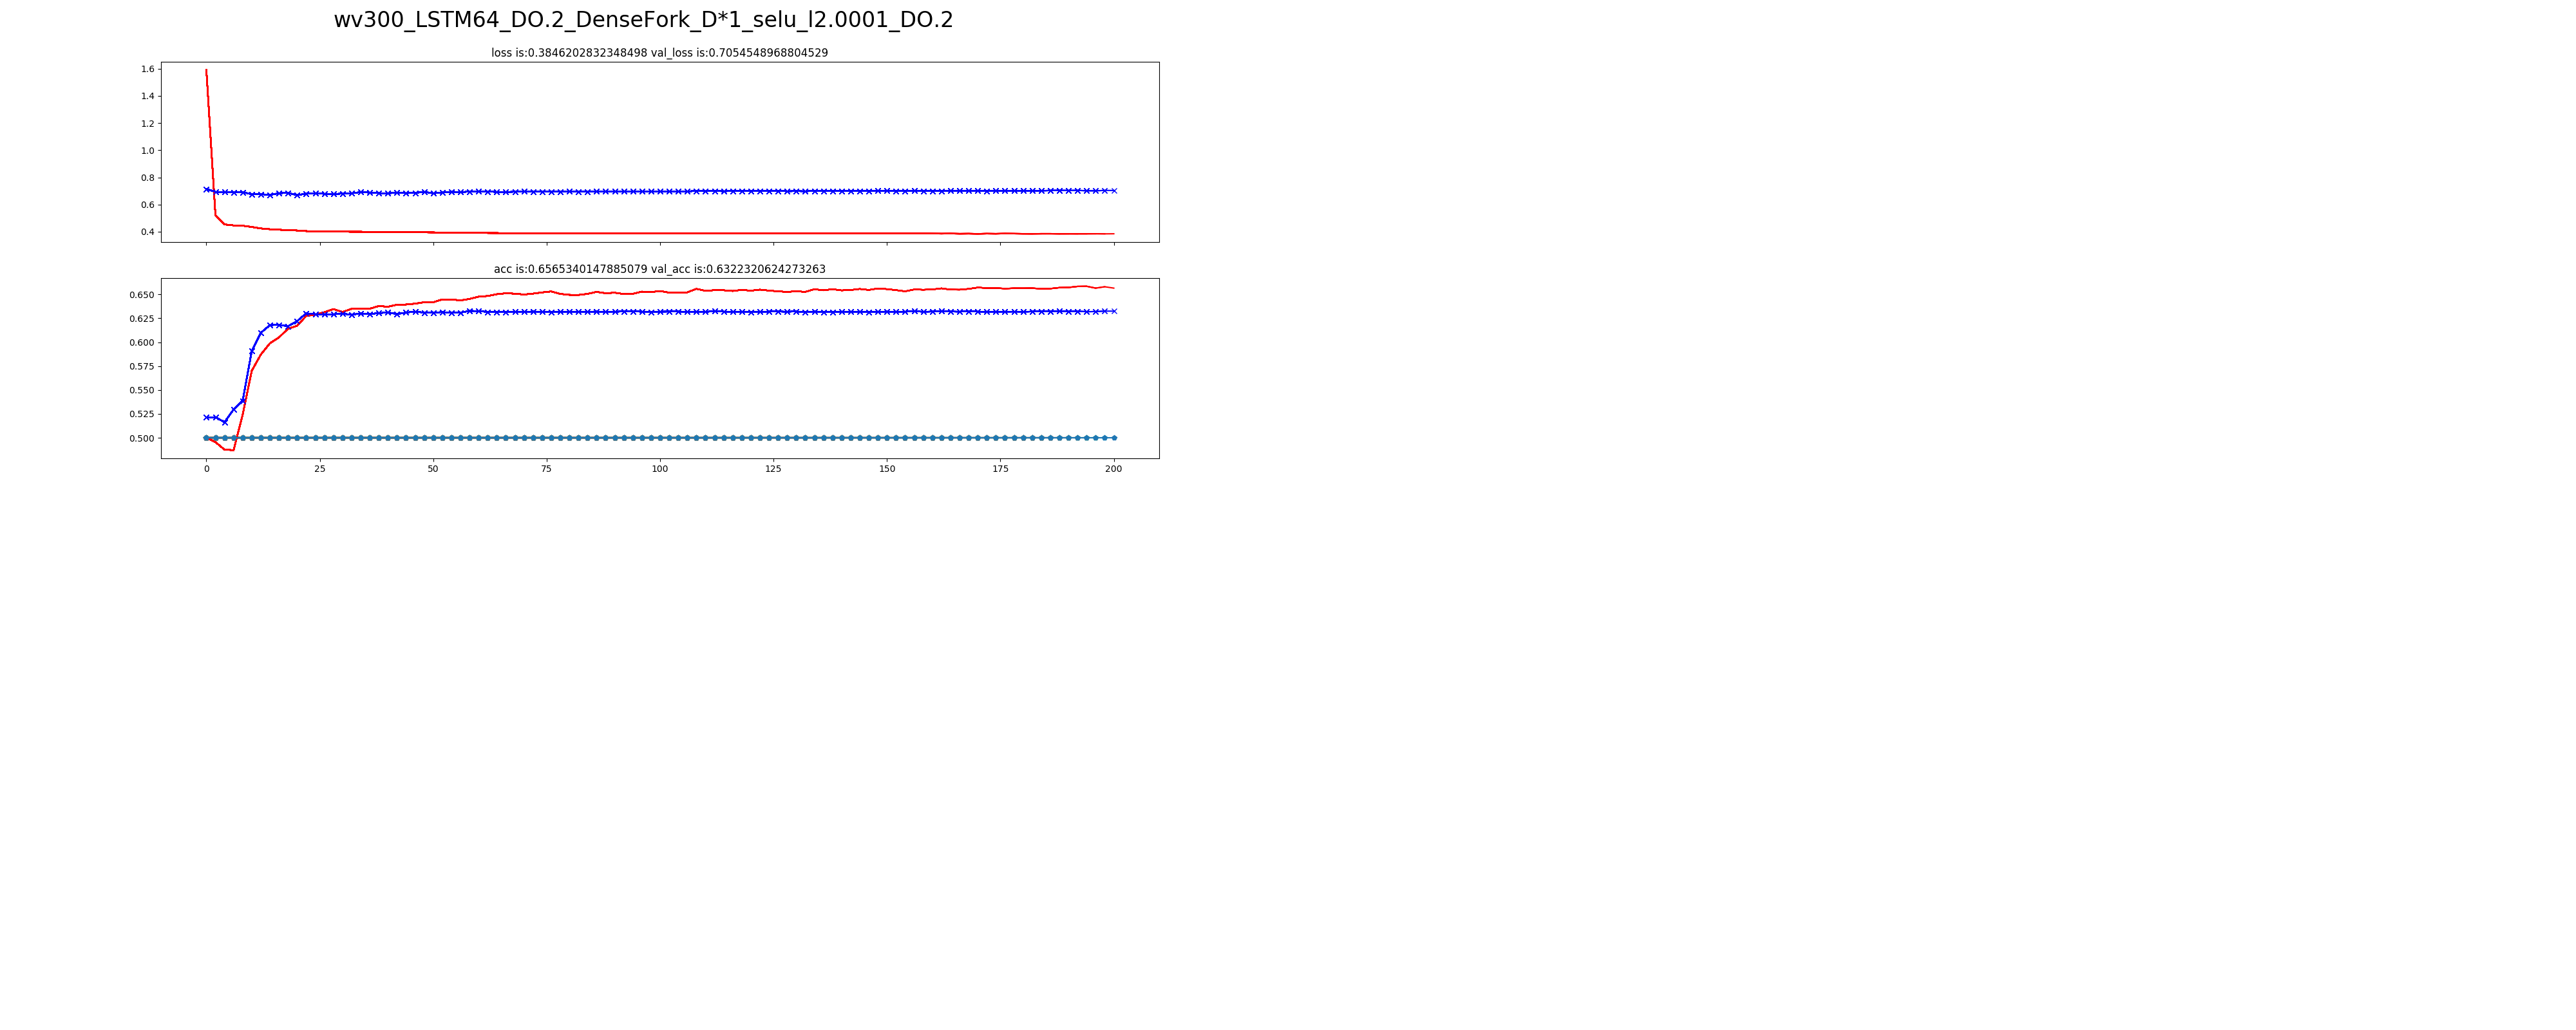

KeyboardInterrupt: 

In [24]:
# configurate model training
desc_rnn_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

# do training
VisualizeCallback.interval = 2
VisualizeCallback.title = "wv300_LSTM64_DO.2_DenseFork_D*1_selu_l2.0001_DO.2"
desc_rnn_model.fit(train_data['texts'], train_data['results_double'], epochs=1000, batch_size=256, shuffle=True,
                  verbose=0, validation_data=[test_data["texts"], test_data['results_double']], 
                  callbacks=[ReduceLROnPlateau(patience=10, min_lr=0.00001, cooldown=30), VisualizeCallback],
                   sample_weight=train_data['result_class_weight'])

desc_rnn_model.save("desc_data/desc_rnn_model_" + VisualizeCallback.title + ".hdf5")

In [25]:
scores = desc_rnn_model.evaluate(x=[test_data['texts']], y=[test_data['results_double']])
print(scores)
desc_rnn_model.save("desc_data/desc_rnn_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

37714/37714 [==============================] - 8s 206us/step
[0.70384151002992446, 0.63241766982134939]


# Now add comparison to "goal"

In [209]:
def MultiLayerLSTMCell(sequence_input, dropout_level=0.2, layer_num=1, layer_width=32):
    this_input = sequence_input
    for i in range(layer_num):
        if i == layer_num - 1:
            is_return_sequence = False
        else:
            is_return_sequence = True
        x = LSTM(units=layer_width, dropout=dropout_level, name="Recurrent_" + str(i), 
                 return_sequences=is_return_sequence)(this_input)
        this_input = BatchNormalization()(x)
    return this_input

def DenseNetCell(dense_in, dropout_level=0.25, res_num=1, activation_name="tanh", l2_para=0.001):
    this_input = dense_in
    for i in range(res_num):
        if activation_name != 'selu':
            x = Dense(int(dense_in.shape[1]), activity_regularizer=l2(l2_para))(this_input)
            x = BatchNormalization()(x)
            x = Activation(activation_name)(x) 
            x = Dropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = BatchNormalization()(res_out)
            x = Dropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
        else:
            x = Dense(int(dense_in.shape[1]), kernel_initializer=
                        VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
                        activity_regularizer=l2(l2_para))(this_input)
            x = Activation(activation_name)(x)
            x = AlphaDropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = AlphaDropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
    dense_out = Dense(1)(this_input)
    return dense_out

# generate model for descriptions + goal
# text branch
text_input = Input(shape=(35, word_vector_len))
# lstm feature extraction
x = Bidirectional(LSTM(units=16))(text_input)
# do prediction using dense layers
x = Dense(32, kernel_initializer=VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
         activation='selu')(x)
pred_value = Dense(units=1, activation='elu')(x)
# goal branch
goal_input = Input(shape=(1, ))
# subtract goal from value
dif = subtract(inputs=[pred_value, goal_input])
x = Activation('sigmoid')(dif)
desc_rnn_vanilla_model = Model(inputs=[text_input, goal_input], outputs=[x])

print("model building finished\n", desc_rnn_vanilla_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 35, 300)      0                                            
__________________________________________________________________________________________________
bidirectional_52 (Bidirectional (None, 32)           40576       input_51[0][0]                   
__________________________________________________________________________________________________
dense_85 (Dense)                (None, 32)           1056        bidirectional_52[0][0]           
__________________________________________________________________________________________________
dense_86 (Dense)                (None, 1)            33          dense_85[0][0]                   
__________________________________________________________________________________________________
input_52 (

<IPython.core.display.Javascript object>


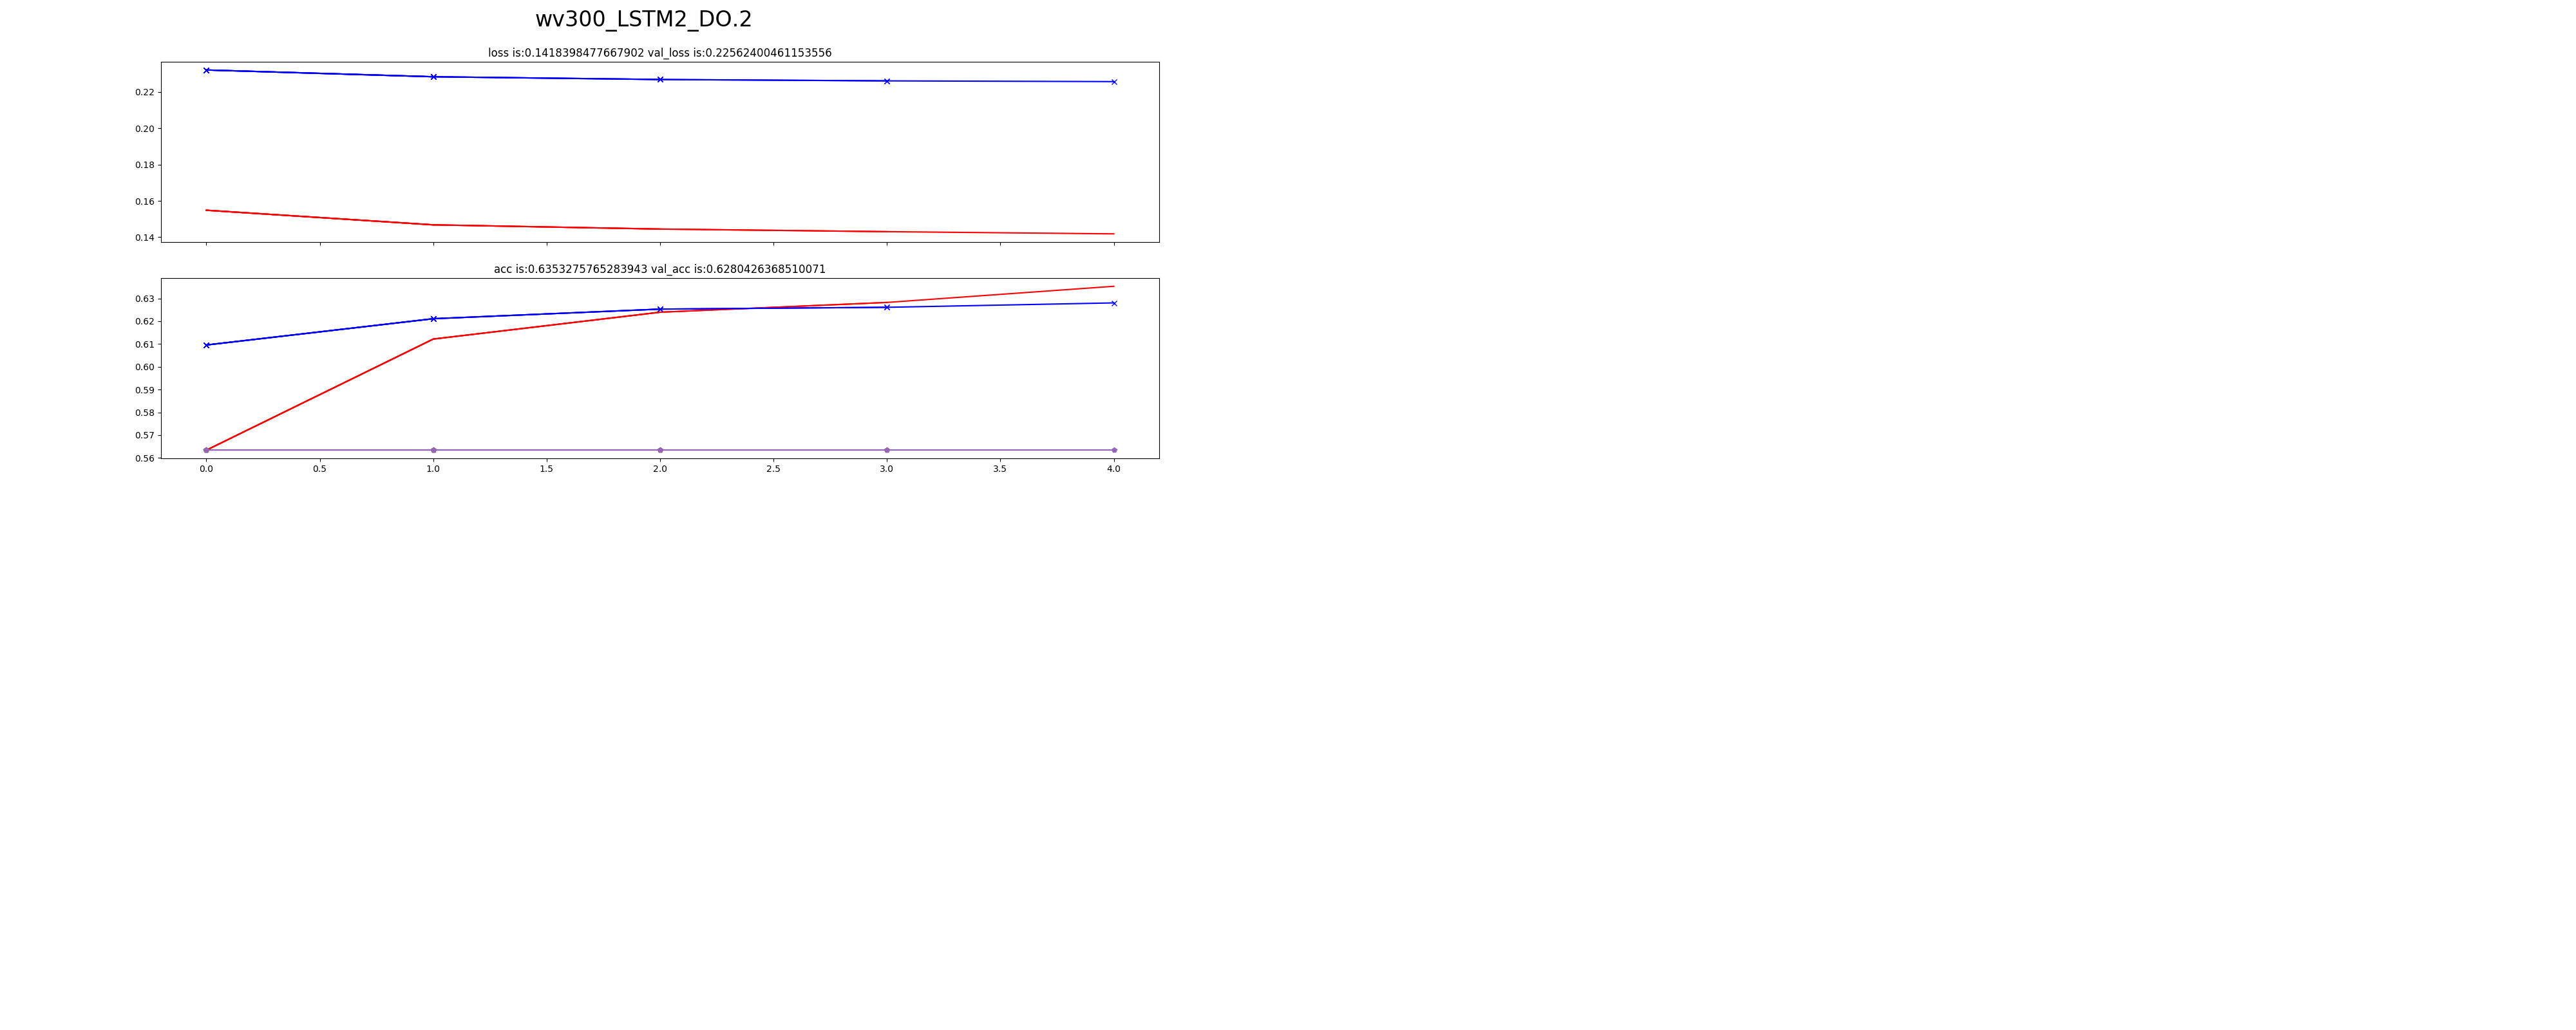

KeyboardInterrupt: 

In [210]:
# configurate model training
desc_rnn_vanilla_model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

# do training
VisualizeCallback.interval = 1
VisualizeCallback.title = "wv300_LSTM2_DO.2"

desc_rnn_vanilla_model.fit([train_data['texts'], train_data['goals']], train_data['results_single'], epochs=1000, batch_size=512, shuffle=True,
                  verbose=1, validation_data=[[test_data['texts'], test_data['goals']], test_data['results_single']], 
                  callbacks=[ReduceLROnPlateau(patience=2, min_lr=0.00001, cooldown=10), VisualizeCallback],
                   sample_weight=train_data['result_class_weight'])

desc_rnn_vanilla_model.save("desc_data/desc_rnn_vanilla_model_" + VisualizeCallback.title + ".hdf5")

In [231]:
func = K.function(inputs=[desc_rnn_vanilla_model.input[0], desc_rnn_vanilla_model.input[1]], outputs=[desc_rnn_vanilla_model.layers[-4].output])
layer_output = func([test_data['texts'], test_data['goals']])
layer_output = [item[0] for item in layer_output[0]]

In [232]:
list(zip(layer_output, test_data['goals']))

[(-0.76712298, array([ 0.02756081])),
 (0.66174448, array([-0.03072705])),
 (-0.89072466, array([-0.03612407])),
 (0.39693615, array([-0.03180645])),
 (0.83187628, array([-0.03310174])),
 (0.6426847, array([-0.02856824])),
 (-0.42512918, array([-0.03288586])),
 (-0.78731418, array([-0.0371495])),
 (1.9709895, array([-0.03450496])),
 (0.62923157, array([-0.01129776])),
 (-0.12529188, array([-0.03180645])),
 (0.65061259, array([-0.03180645])),
 (0.71275294, array([ 0.08153105])),
 (-0.14692384, array([-0.03342556])),
 (0.31415606, array([-0.01021835])),
 (1.3003296, array([-0.03018734])),
 (-0.77444798, array([-0.03396526])),
 (-0.48170555, array([-0.03180645])),
 (-0.18139696, array([ 0.01676677])),
 (0.40462276, array([ 0.05022831])),
 (1.4147803, array([ 0.01676677])),
 (-0.24657899, array([-0.03612407])),
 (0.95621371, array([-0.03612299])),
 (-0.94271791, array([-0.03558437])),
 (0.26432672, array([-0.03450496])),
 (-0.91819113, array([-0.03180645])),
 (-0.77397895, array([ 0.016766

In [ ]:
scores = desc_rnn_vanilla_model.evaluate(x=[test_data['texts'], test_data['goals']], y=[test_data['results_double']])
print(scores)
desc_rnn_vanilla_model.save("desc_data/desc_rnn_vanilla_model_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

# now try backer prediction
## it seems a bad idea to normalize predictions...
## it is really hard to do regression on data that has various output
1. Notice that: Dropout can help reduce overfitting to the average of output
2. 

## add one layer of pretraining

In [290]:
def DenseNetCell(dense_in, dropout_level=0.25, res_num=1, activation_name="tanh", l2_para=0.001):
    this_input = dense_in
    for i in range(res_num):
        if activation_name != 'selu':
            x = Dense(int(dense_in.shape[1]), activity_regularizer=l2(l2_para))(this_input)
            x = BatchNormalization()(x)
            x = Activation(activation_name)(x) 
            x = Dropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = BatchNormalization()(res_out)
            x = Dropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
        else:
            x = Dense(int(dense_in.shape[1]), kernel_initializer=
                        VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
                        activity_regularizer=l2(l2_para))(this_input)
            x = Activation(activation_name)(x)
            x = AlphaDropout(dropout_level)(x)
            x = add(inputs=[this_input, x])
            x = AlphaDropout(dropout_level)(x)
            this_input = Activation(activation_name)(x)
    dense_out = Dense(1)(this_input)
    return dense_out

text_input = Input(shape=(35, word_vector_len))
# lstm feature extraction
x = LSTM(units=32, dropout=0.2)(text_input)
x = concatenate(inputs=[DenseNetCell(x, dropout_level=0.2, res_num=2, activation_name="selu", l2_para=0.0001), 
                               DenseNetCell(x, dropout_level=0.2, res_num=2, activation_name="selu", l2_para=0.0001)])
x = Activation("selu")(x)
x = Activation("softmax")(x)

desc_rnn_backer_model = Model(inputs=[text_input], outputs=[x])
desc_rnn_backer_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           (None, 35, 300)      0                                            
__________________________________________________________________________________________________
lstm_56 (LSTM)                  (None, 32)           42624       input_56[0][0]                   
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 32)           1056        lstm_56[0][0]                    
__________________________________________________________________________________________________
dense_105 (Dense)               (None, 32)           1056        lstm_56[0][0]                    
__________________________________________________________________________________________________
activation

# warning reduceLROnPlateau too early may lead to stagnation of learning

Train on 48523 samples, validate on 37714 samples


<IPython.core.display.Javascript object>


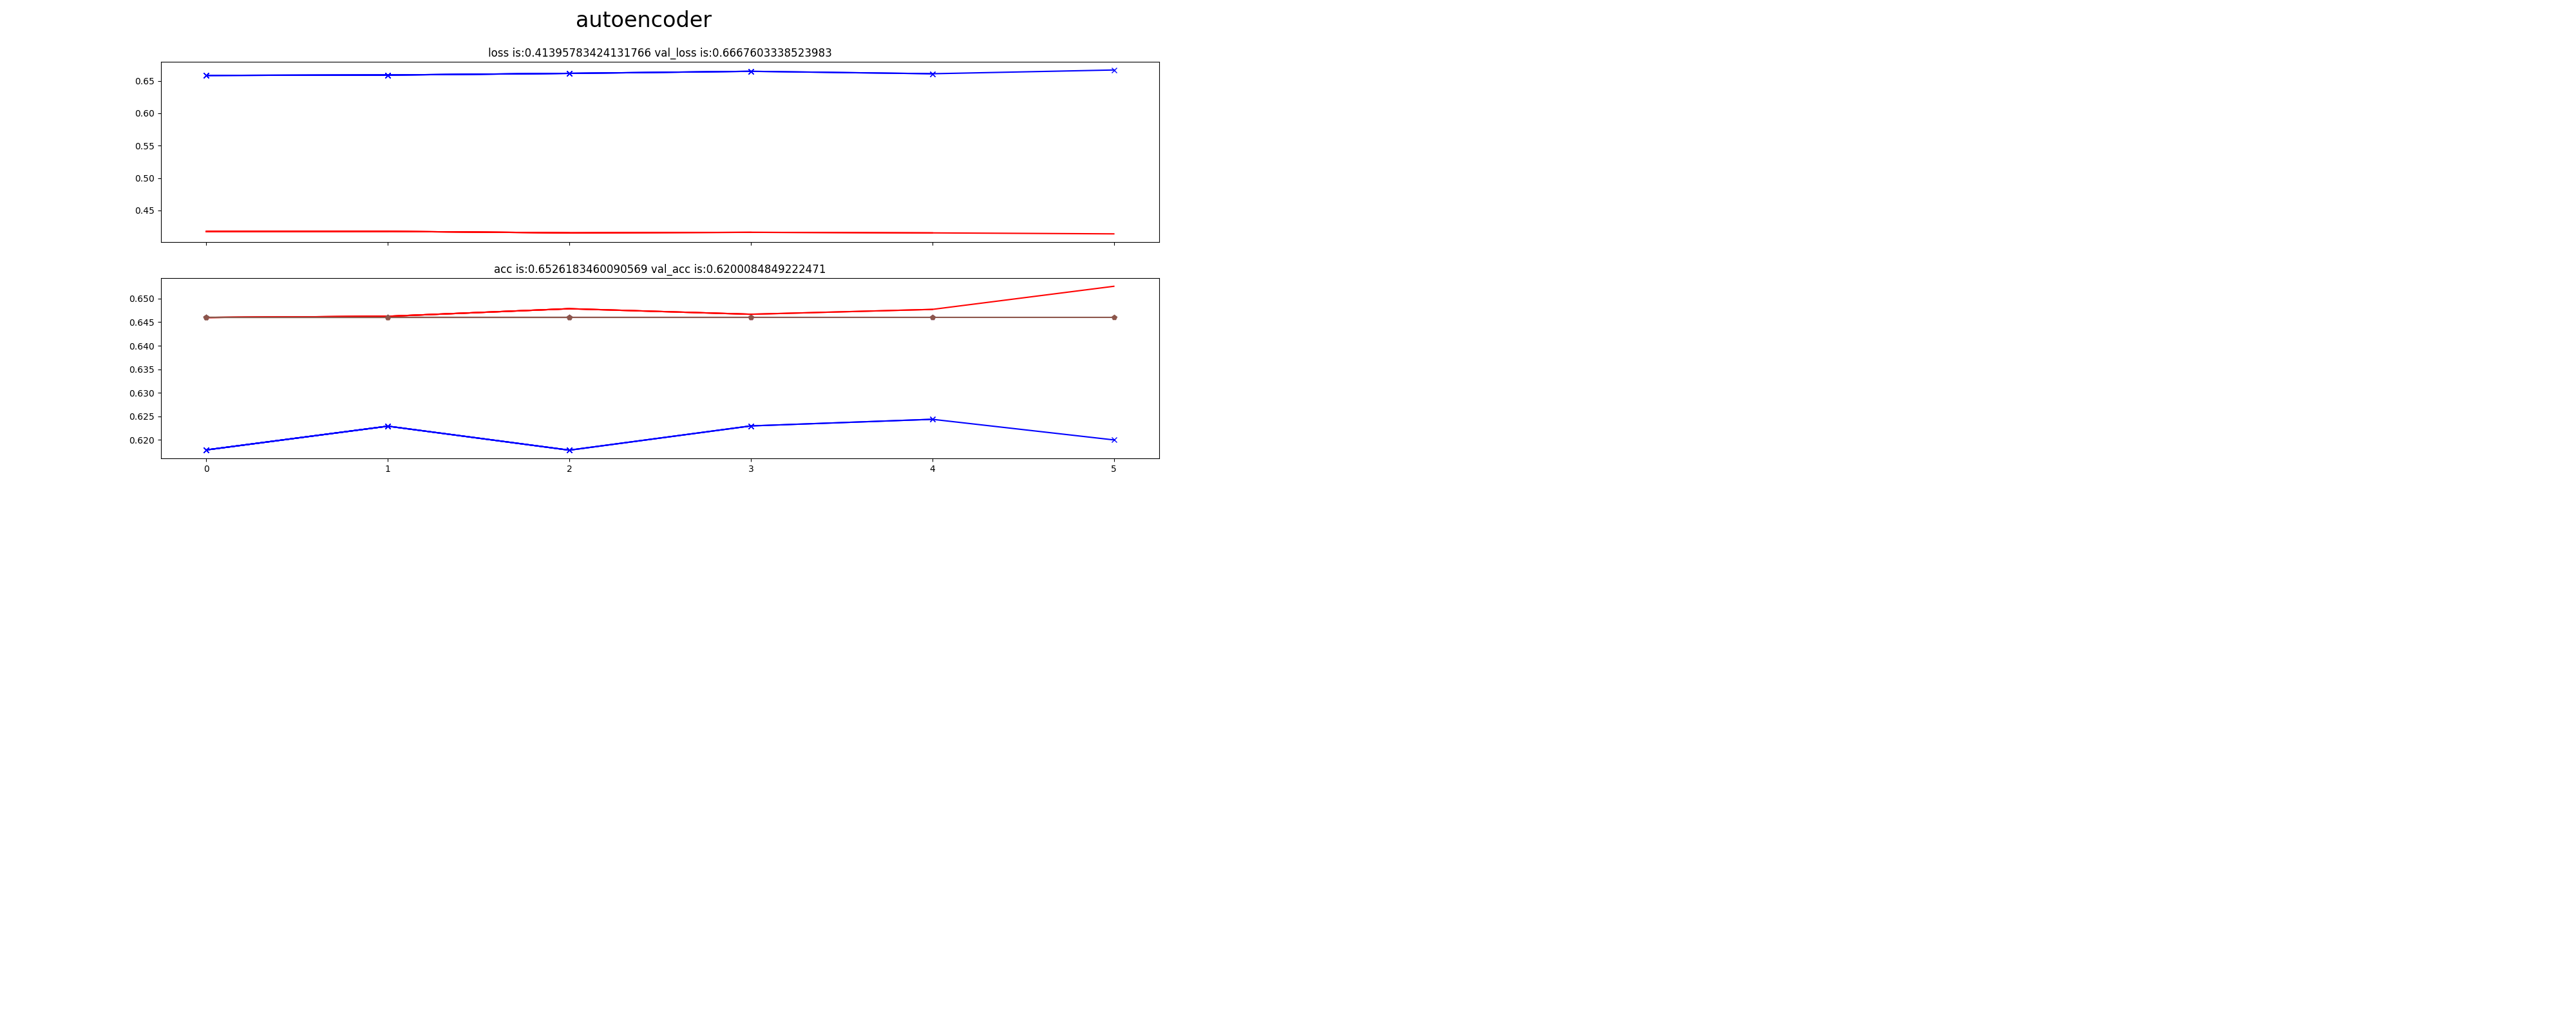

Epoch 1/1000
48523/48523 [==============================] - 38s 786us/step - loss: 0.4176 - acc: 0.6460 - val_loss: 0.6584 - val_acc: 0.6179
Epoch 2/1000
48523/48523 [==============================] - 24s 501us/step - loss: 0.4178 - acc: 0.6463 - val_loss: 0.6590 - val_acc: 0.6229
Epoch 3/1000
48523/48523 [==============================] - 20s 413us/step - loss: 0.4155 - acc: 0.6479 - val_loss: 0.6616 - val_acc: 0.6178
Epoch 4/1000
48523/48523 [==============================] - 20s 414us/step - loss: 0.4163 - acc: 0.6467 - val_loss: 0.6647 - val_acc: 0.6230
Epoch 5/1000
48523/48523 [==============================] - 19s 390us/step - loss: 0.4155 - acc: 0.6477 - val_loss: 0.6610 - val_acc: 0.6244
Epoch 6/1000
48523/48523 [==============================] - 20s 404us/step - loss: 0.4140 - acc: 0.6526 - val_loss: 0.6668 - val_acc: 0.6200
Epoch 7/1000
48523/48523 [==============================] - 20s 403us/step - loss: 0.4130 - acc: 0.6534 - val_loss: 0.6746 - val_acc: 0.6204
Epoch 8/1000


In [ ]:
# configurate model training
desc_rnn_backer_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

# do training
VisualizeCallback.interval = 1
VisualizeCallback.title = "autoencoder"

desc_rnn_backer_model.fit(train_data['texts'], train_data['results_double'], epochs=1000, batch_size=256, shuffle=True,
                  verbose=1, validation_data=[test_data['texts'], test_data['results_double']], 
                  callbacks=[ReduceLROnPlateau(patience=10, min_lr=0.00001, cooldown=10), VisualizeCallback],
                   sample_weight=train_data['result_class_weight'])

desc_rnn_backer_model.save("desc_data/desc_rnn_vanilla_model_" + VisualizeCallback.title + ".hdf5")

In [279]:
# generate model for descriptions -> bakers
while len(desc_rnn_backer_model.layers) > 2:
    desc_rnn_backer_model.layers.pop()
for layer in desc_rnn_backer_model.layers:
    layer.trainable = False
print(desc_rnn_backer_model.get_config())
# do prediction using dense layers
x = Dense(128, kernel_initializer=VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
         activation='selu')(x)
x = AlphaDropout(0.5)(x)
x = Dense(128, kernel_initializer=VarianceScaling(scale=1.0, mode='fan_in', distribution='normal'), 
         activation='selu')(x)
x = AlphaDropout(0.5)(x)
x = Dense(1)(x)
desc_rnn_backer_model = Model(inputs=[text_input], outputs=[x])

print("model building finished\n", desc_rnn_backer_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 35, 300)           0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 8)                 9888      
Total params: 10,242
Trainable params: 10,242
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 35, 300)           0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 8)                 9888      
_________________________________________________________________
dense_98 (Dense)             (None, 256)               2304      
_________________________________________________________________
b

/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [282]:
for layer in desc_rnn_backer_model.layers:
    layer.trainable = True

Train on 48523 samples, validate on 37714 samples


<IPython.core.display.Javascript object>


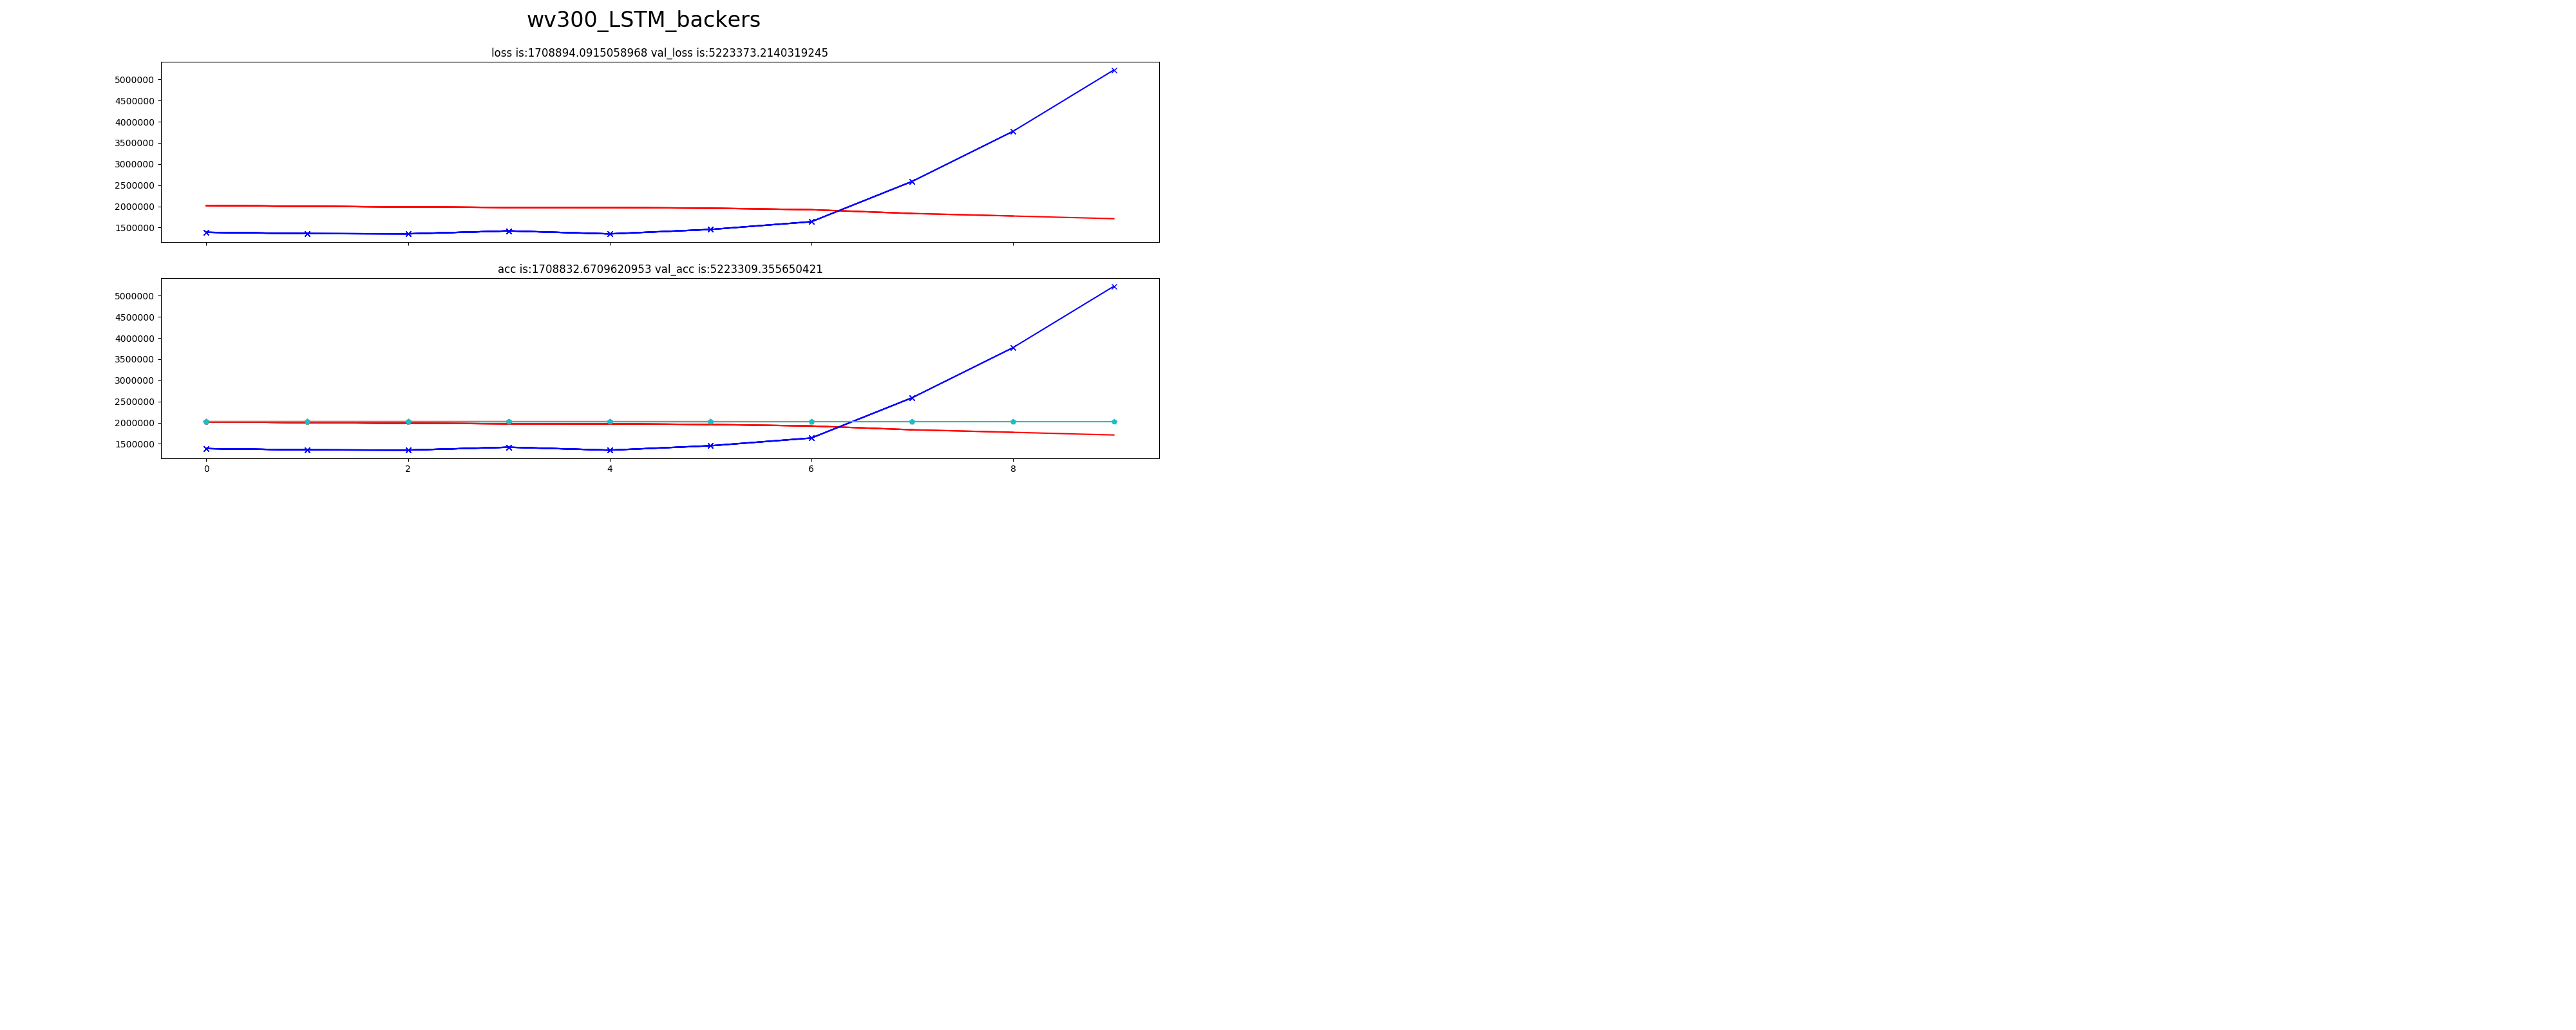

Epoch 1/1000
48523/48523 [==============================] - 31s 648us/step - loss: 2021364.4247 - mean_squared_error: 2021361.1149 - val_loss: 1387018.3921 - val_mean_squared_error: 1387012.2106
Epoch 2/1000
48523/48523 [==============================] - 20s 414us/step - loss: 2001215.9755 - mean_squared_error: 2001205.4356 - val_loss: 1357032.4243 - val_mean_squared_error: 1357020.5677
Epoch 3/1000
48523/48523 [==============================] - 22s 453us/step - loss: 1986746.3656 - mean_squared_error: 1986728.1081 - val_loss: 1352085.3758 - val_mean_squared_error: 1352066.2543
Epoch 4/1000
48523/48523 [==============================] - 21s 428us/step - loss: 1974494.2573 - mean_squared_error: 1974470.5218 - val_loss: 1420139.1309 - val_mean_squared_error: 1420109.2437
Epoch 5/1000
48523/48523 [==============================] - 20s 406us/step - loss: 1972964.8746 - mean_squared_error: 1972943.0549 - val_loss: 1350539.2926 - val_mean_squared_error: 1350517.4368
Epoch 6/1000
48523/48523 

KeyboardInterrupt: 

In [281]:
# configurate model training
desc_rnn_backer_model.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['mse'])

# do training
VisualizeCallback.interval = 1
VisualizeCallback.title = "wv300_LSTM_backers"

desc_rnn_backer_model.fit(train_data['texts'], train_data['backers'], epochs=1000, batch_size=1024, shuffle=True,
                  verbose=1, validation_data=[test_data['texts'], test_data['backers']], 
                  callbacks=[ReduceLROnPlateau(patience=2, min_lr=0.0001, cooldown=10), VisualizeCallback])

desc_rnn_backer_model.save("desc_data/desc_rnn_backer_model_" + VisualizeCallback.title + ".hdf5")

# investigate backer estimation

In [283]:
desc_rnn_backer_model.layers[-1].get_weights()

[array([[-0.0634176 ],
        [ 1.99056995],
        [-0.28124058],
        [ 1.81831098],
        [ 1.96465707],
        [-1.86375093],
        [-0.12912486],
        [-1.88461101],
        [ 1.69734251],
        [ 1.55380821],
        [-2.00605631],
        [-2.1267817 ],
        [-1.99591148],
        [ 1.8478843 ],
        [-0.26273054],
        [ 1.66415989],
        [-2.22640491],
        [ 1.78269613],
        [-0.11137275],
        [ 1.71575606],
        [-2.22255015],
        [ 0.14547938],
        [-2.14310074],
        [-2.14777422],
        [-2.0563302 ],
        [ 0.52189553],
        [ 1.63659263],
        [-2.24931359],
        [-1.95785904],
        [-2.30389929],
        [-2.05842876],
        [-2.11566448],
        [-1.86856949],
        [-2.0241766 ],
        [ 1.72577107],
        [-1.91078794],
        [ 0.12591246],
        [ 1.81201947],
        [-1.96095479],
        [-1.82783175],
        [-0.91663378],
        [-1.97928107],
        [-2.40083838],
        [ 1

In [285]:
backer_model = desc_rnn_backer_model
result = [item[0] for item in backer_model.predict_on_batch(train_data['texts'])]
list(zip(result, train_data['backers']))

[(113.2242, 100),
 (-1932.1372, 12),
 (-1646.6421, 11),
 (-1166.2135, 3),
 (-2048.4944, 1),
 (-2217.4482, 7),
 (-1435.9592, 6),
 (-2094.1824, 0),
 (-2236.0249, 35),
 (6293.6597, 14),
 (-1150.3418, 16),
 (5907.7842, 4),
 (-2092.2051, 3),
 (-2105.3906, 1),
 (-1306.2979, 21),
 (-877.59869, 19),
 (-1178.9875, 18),
 (-1236.7971, 20),
 (-1751.4141, 44),
 (-1929.3491, 2),
 (-1524.7209, 1),
 (-1785.4594, 13),
 (-2080.2917, 0),
 (-852.18152, 62),
 (-2211.8618, 1),
 (-2078.2202, 13),
 (-1879.6208, 48),
 (118.6375, 115),
 (-2225.0627, 8),
 (-2305.752, 1),
 (-2121.7839, 9),
 (-2004.5198, 0),
 (-2115.0879, 0),
 (-1438.8145, 13),
 (-2127.0083, 5),
 (-1834.0049, 11),
 (-632.55627, 10),
 (1005.0464, 25),
 (-1704.0067, 5),
 (-1936.0338, 121),
 (-20.976894, 2253),
 (-1925.1936, 36),
 (30.143713, 69),
 (-1585.988, 2),
 (-1047.5431, 178),
 (-1343.4495, 43),
 (-353.87436, 51),
 (-1961.0476, 90),
 (-1518.1699, 94),
 (-2142.98, 13),
 (-1898.8586, 9),
 (-2019.1987, 33),
 (-2068.281, 4),
 (-1191.098, 316),
 (-

In [205]:
func = K.function(inputs=[backer_model.input, K.learning_phase()], outputs=[backer_model.layers[-3].output])
output = func([test_data['texts'], 0])

In [207]:
[item for item in output[0]]

[array([-0.53183371,  0.71854866, -0.82233953, -0.12222264, -1.44100475,
         0.34188586, -0.96314847, -0.58373624, -1.50878477,  0.04910205,
        -1.74573517, -0.20682524,  0.30285922, -0.74091339, -0.66768789,
        -0.11987349,  0.10753182, -2.61447048, -0.3070024 , -0.02623019,
        -1.58485818,  0.09281521, -1.02544522, -0.34362662, -0.30663389,
        -1.20366228, -0.33429253, -0.67130923, -1.46239841, -2.90353084,
         0.14855567, -1.77725911,  1.38799322, -0.13249981, -1.00638056,
        -0.60262364, -0.39964712, -1.34579504, -0.39883032, -0.59848112,
        -0.32266453, -2.92187595,  0.31139511, -1.55435705, -0.59865677,
        -1.21175134, -0.71492529, -0.375267  , -0.8430863 , -0.57971638,
        -1.59976077, -2.65190697, -0.57177716, -1.76495934, -0.03980537,
        -0.57441944, -0.95335418, -0.97232997, -0.73389101,  0.39953217,
        -1.28236365, -0.27288312, -1.33954835, -0.77911711, -0.53510177,
        -1.26149607, -0.62438405, -0.97591937,  0.2

# investigating the statistics of prediction
* for random guesses, correct prediction rate for 1 should equal to the frequency of 1 in data set, vice versa

In [113]:
zeros = 0.0
ones = 0.0
for i in test_data['results_double']:
    if i[0] == 0:
        zeros += 1
    else:
        ones += 1
print("frequency of zero is: ", zeros/(ones+zeros))

# get predictions
desc_model = desc_rnn_vanilla_model
try:
    result = [1 if item[0] > item[1] else 0 for item in desc_model.predict_on_batch(test_data['texts'])]
    # get predicted statistics
    pred_zeros = float(len([1 for item in result if item == 0]))
    pred_ones = float(len(result) - pred_zeros)
    print("predicted frequency of zero is: ", pred_zeros/len(result))

    # get right statistics
    right_ones = float(len([1 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 1]))
    right_zeros = float(len([0 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 0]))
    print("correct rate for 1 predictions: ",   right_ones / pred_ones)
    print("proportion of correct 1 predictions: ", right_ones / ones)
    print("correct rate for 0 predictions: ",   right_zeros / pred_zeros)
    print("proportion of correct 0 predictions: ", right_zeros / zeros)

    print("overall accuracy is: ", (right_zeros + right_ones) / len(result))
except:
    result = [1 if item > 0.5 else 0 for item in desc_model.predict_on_batch([test_data['texts'], test_data['goals']])]
    # get predicted statistics
    pred_zeros = float(len([1 for item in result if item == 0]))
    pred_ones = float(len(result) - pred_zeros)
    print("predicted frequency of zero is: ", pred_zeros/len(result))

    # get right statistics
    right_ones = float(len([1 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 1]))
    right_zeros = float(len([0 for i in range(len(result)) if test_data['results_single'][i] == result[i] and result[i] == 0]))
    print("correct rate for 1 predictions: ",   right_ones / pred_ones)
    print("proportion of correct 1 predictions: ", right_ones / ones)
    print("correct rate for 0 predictions: ",   right_zeros / pred_zeros)
    print("proportion of correct 0 predictions: ", right_zeros / zeros)

    print("overall accuracy is: ", (right_zeros + right_ones) / len(result))

frequency of zero is:  0.5000265153523891
predicted frequency of zero is:  0.5611178872567216
correct rate for 1 predictions:  0.639258095698405
proportion of correct 1 predictions:  0.561147645311837
correct rate for 0 predictions:  0.6089689065305737
proportion of correct 0 predictions:  0.6833704528582034
overall accuracy is:  0.6222622898658323


In [19]:
func = K.function(inputs=[desc_model.input, K.learning_phase()], outputs=[desc_model.layers[-2].output])
second_last_layer_output = func([test_data['texts'], 0])

In [20]:
[item for item in second_last_layer_output[0]]

[array([ 1.17666662,  1.91166806], dtype=float32),
 array([-0.33087325,  0.61778414], dtype=float32),
 array([-1.06526256, -0.8415361 ], dtype=float32),
 array([-1.07294571, -1.6218971 ], dtype=float32),
 array([ 0.09263682,  0.0226647 ], dtype=float32),
 array([ 0.11063059, -1.08550906], dtype=float32),
 array([ 0.69241846,  2.10820842], dtype=float32),
 array([-0.68021482,  0.1506452 ], dtype=float32),
 array([-1.09966195,  0.3515954 ], dtype=float32),
 array([-0.96627849, -1.55823994], dtype=float32),
 array([ 0.7631017 ,  0.62607723], dtype=float32),
 array([-1.45100439, -1.16533792], dtype=float32),
 array([-0.48573354, -0.02216338], dtype=float32),
 array([-1.31567502, -1.21677089], dtype=float32),
 array([-0.94593751, -0.30448586], dtype=float32),
 array([ 1.67814779,  0.07919337], dtype=float32),
 array([ 0.07376346,  0.19657829], dtype=float32),
 array([-0.41954654, -0.02781548], dtype=float32),
 array([ 0.80225134,  1.17598164], dtype=float32),
 array([-1.24695337, -1.0315851

In [30]:
probability_output = [list(item) for item in desc_model.predict_on_batch(test_data['texts'])]
list(zip(probability_output, test_data['results_double']))

[([0.24938218, 0.7506178], array([0, 1])),
 ([0.30294791, 0.69705212], array([0, 1])),
 ([0.52424896, 0.47575104], array([0, 1])),
 ([0.68811399, 0.31188598], array([1, 0])),
 ([0.59332556, 0.40667439], array([0, 1])),
 ([0.72010189, 0.27989808], array([1, 0])),
 ([0.10520472, 0.89479524], array([0, 1])),
 ([0.51162875, 0.48837122], array([0, 1])),
 ([0.29102322, 0.70897681], array([1, 0])),
 ([0.60400593, 0.39599404], array([0, 1])),
 ([0.69813949, 0.30186054], array([0, 1])),
 ([0.45293349, 0.54706651], array([0, 1])),
 ([0.45922989, 0.54077011], array([1, 0])),
 ([0.61776698, 0.38223302], array([0, 1])),
 ([0.59643346, 0.40356648], array([0, 1])),
 ([0.82911164, 0.17088839], array([1, 0])),
 ([0.61210048, 0.38789949], array([1, 0])),
 ([0.58999467, 0.41000533], array([1, 0])),
 ([0.56367797, 0.43632206], array([0, 1])),
 ([0.54419845, 0.45580155], array([1, 0])),
 ([0.57712507, 0.4228749], array([1, 0])),
 ([0.23460397, 0.765396], array([0, 1])),
 ([0.60835403, 0.39164594], array([1